In [18]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support as score

precision: [1.  1.  1.  1.  0.5]
recall: [0.8 1.  1.  1.  1. ]
fscore: [0.88888889 1.         1.         1.         0.66666667]
support: [5 2 1 2 1]


<Axes: xlabel='Class', ylabel='Metrics'>

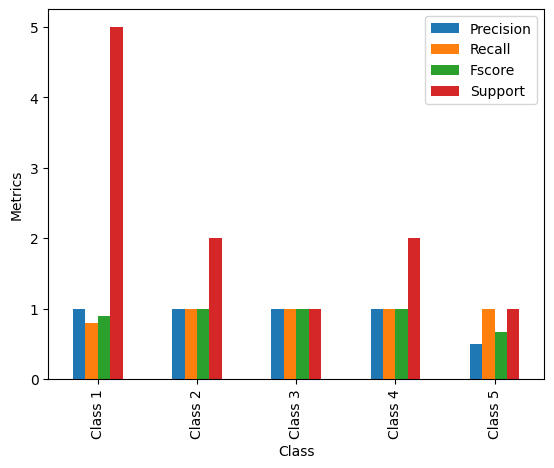

In [26]:
predicted = [1,2,3,4,5,1,2,1,1,4,5] 
y_test = [1,2,3,4,5,1,2,1,1,4,1]

precision, recall, fscore, support = score(y_test, predicted)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'Fscore': fscore, 'Support': support})

# Adjust x-axis labels
x_labels = ['Class {}'.format(i+1) for i in range(len(metrics_df))]
metrics_df.index = x_labels
metrics_df.plot(kind='bar', xlabel='Class', ylabel='Metrics')
